In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch, time
import numpy as np
from first_gm import plot_SM, plot_raster, gaussian_kernel, tensor2spikeship

## Raster plot generative model with a superposition of SMs
### Parameters

In [3]:
class world_params:
    N_pre = 200 # number of neurons in the RP
    N_delays = 51 # number of timesteps in the SM (must be an odd number for convolutions)
    N_kernels = 2 # number of SM used for RP generation
    
    p_input = .05 # global probability of having a spike in the timebins of the RP as input
    sm_ratio = .5 # probability of a spike as input to belong to the SM
    p_spontaneous =  p_input*(1-sm_ratio) 
    p_spike_in_motif = p_input*sm_ratio # probability of having a spike in the timebins of the SM
    
    avg_N_spikes = p_spike_in_motif*N_delays*N_pre
    std_N_spikes = 1

    N_timesteps =  N_delays # number of timesteps in the RP
    
    avg_precision = 10 # average precision for the spikes in the SM (inverse of variance of the gaussian distribution defined for 1 spike)
    std_precision = 1 # variance for the precision
    
    seed = 4815162342 # seed

In [4]:
class SM_World:
    def __init__(self, opt, add_coef = None):
        # initialization of the parameters + drawing of the kernels
        # here one of the kernels is a combination of the 2 first ones with parameter add_coef ([0,1])
        self.opt: Params = opt
        self.add_coef = add_coef
        if add_coef:
            self.kernels = torch.zeros(self.opt.N_kernels+1, self.opt.N_pre, self.opt.N_delays)
        else:
            self.kernels = torch.zeros(self.opt.N_kernels, self.opt.N_pre, self.opt.N_delays)
            
        for k in range(self.kernels.shape[0]):
            nb_spikes = int(torch.normal(torch.Tensor([self.opt.avg_N_spikes]), torch.Tensor([self.opt.std_N_spikes])).abs())
            addr, delay, precision = (torch.randint(self.opt.N_pre, [nb_spikes]), torch.randint(self.opt.N_delays, [nb_spikes]), torch.normal(torch.ones([nb_spikes])*self.opt.avg_precision, torch.ones([nb_spikes])*self.opt.std_precision).abs())
            for s in range(nb_spikes):
                self.kernels[k, addr[s], :] += gaussian_kernel(self.opt.N_delays, delay[s], 1/precision[s])
            if self.kernels[k, :, :].max()>1: self.kernels[k, :,:]/=self.kernels[k, :, :].max()
        if add_coef:
            self.kernels[-1, :, :] = (1-add_coef)*self.kernels[0, :, :] + add_coef*self.kernels[1, :, :]
                
    def draw_input_one_sm(self, N_trials = 1, do_channels = False):
        
        spontaneous_activity = torch.bernoulli(torch.ones([N_trials, self.opt.N_pre, self.opt.N_timesteps])*self.opt.p_spontaneous)
        labels = torch.randint(self.kernels.shape[0]+1, [N_trials])
        
        output_labels = labels.clone().detach().to(torch.float32)
        output_labels[output_labels==self.kernels.shape[0]] = -1
        output_labels[(output_labels==self.kernels.shape[0]-1)] = self.add_coef
        
        if do_channels:
            input_rp_with_channels = torch.zeros([self.kernels.shape[0]+1, N_trials, self.opt.N_pre, self.opt.N_timesteps])
            input_rp_with_channels[0,:,:,:] = spontaneous_activity
            for k in range(self.kernels.shape[0]):
                indices = labels==k
                trials = torch.bernoulli(self.kernels[k,:,:].unsqueeze(0).repeat(indices.sum(),1,1))
                input_rp_with_channels[k+1,indices,:,:] = trials
            return input_rp_with_channels, output_labels
        else:
            input_rp = torch.zeros([N_trials, self.opt.N_pre, self.opt.N_timesteps])
            indices_spont = labels==self.kernels.shape[0]+1
            input_rp[indices_spont,:,:] = spontaneous_activity[indices_spont]
            for k in range(self.kernels.shape[0]):
                indices = labels==k
                trials = torch.bernoulli(self.kernels[k,:,:].unsqueeze(0).repeat(indices.sum(),1,1))
                input_rp[indices,:,:] = torch.max(trials, spontaneous_activity[indices])
            return input_rp, output_labels

TODO: change something in the formula with SM_ratio

### Generative model without motif non overlapping

In [5]:
N_trials = 10
add_coef = .2 # coeff for the combination of the 2 patterns/motifs -> hyperparameter of the SM_World class (could be defined as random is necessary)

opt = world_params()
world = SM_World(opt, add_coef = add_coef)
input_rp, labels = world.draw_input_one_sm(N_trials = N_trials, do_channels = True) # do_channels = True for colored plot only

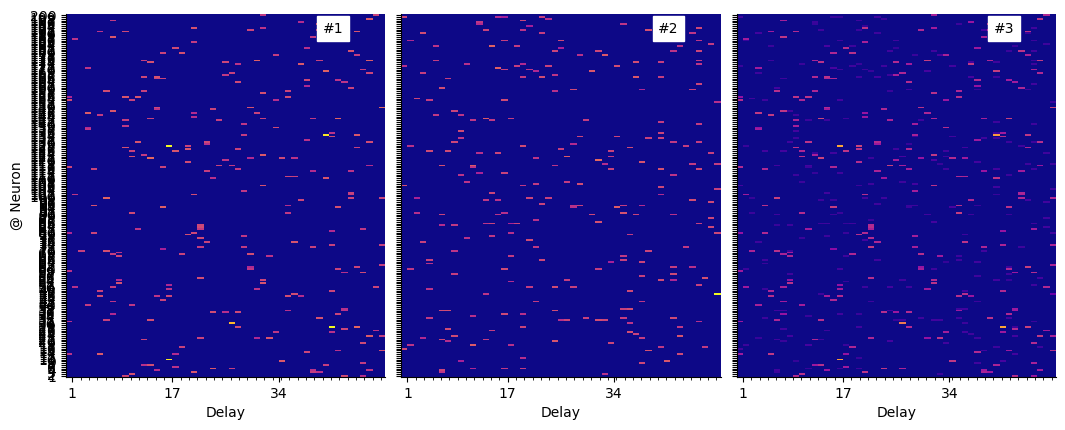

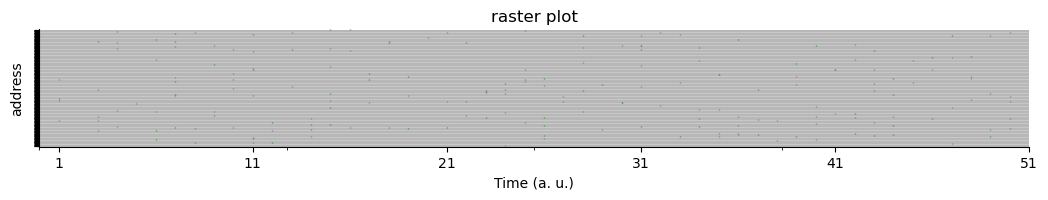

In [6]:
plot_SM(world.kernels, N_show = opt.N_kernels+1, figsize = (12, 5));
plot_raster(input_rp, colored=True);

In [7]:
stacked_input = torch.Tensor([])
stacked_labels = torch.Tensor([])
for add_coef in [0, 0.2, 0.4, 0.6, 0.8, 1]:
    N_trials = 100
    world.add_coef = add_coef
    world.kernels[-1, :, :] = (1-add_coef)*world.kernels[0, :, :] + add_coef*world.kernels[1, :, :]
    input_rp, output_labels = world.draw_input_one_sm(N_trials = N_trials)
    stacked_input = torch.vstack([stacked_input,input_rp]) if stacked_input.shape[0]>0 else input_rp
    stacked_labels = torch.hstack([stacked_labels,output_labels]) if stacked_input.shape[0]>0 else output_labels
spike_times, ii_spike_times = tensor2spikeship(stacked_input)

  0%|          | 0/600 [00:00<?, ?it/s]

(array([2.7807e+04, 0.0000e+00, 0.0000e+00, 8.0000e+00, 0.0000e+00,
        0.0000e+00, 7.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 3.06590e+03, 6.13080e+03, 9.19570e+03, 1.22606e+04,
        1.53255e+04, 1.83904e+04, 2.14553e+04, 2.45202e+04, 2.75851e+04,
        3.06500e+04]),
 <BarContainer object of 10 artists>)

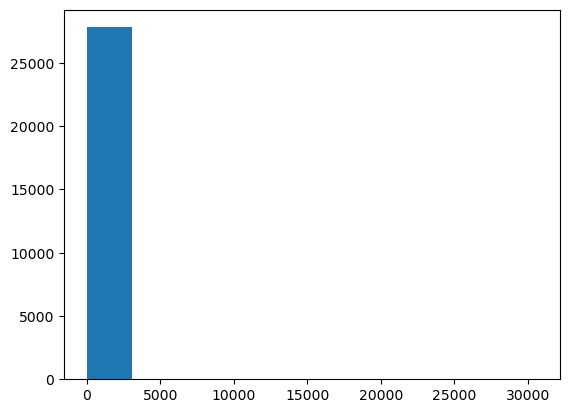

In [26]:
import matplotlib.pyplot as plt
isi = np.diff(np.where(input_rp.flatten()>0)[0])
plt.hist(isi)#.shape

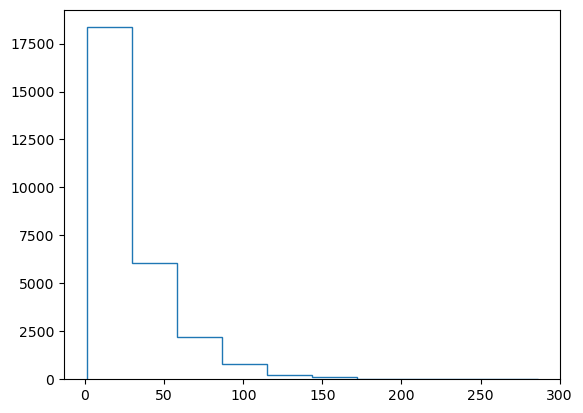

In [30]:
counts, bins = np.histogram(isi[isi<5000])
plt.stairs(counts, bins)

In [17]:
np.where(input_rp.ravel()>0)[0]

array([     46,      69,     135, ..., 1019948, 1019982, 1019992])

In [22]:
print(input_rp.shape)

input_rp.flatten(end_dim=1)

torch.Size([100, 200, 51])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [24]:
tensor = torch.randint(100,[2,5,10])
print(tensor)

tensor([[[97, 82, 38, 11,  0, 32, 18, 90, 31,  2],
         [ 5, 12, 59, 90, 75, 69, 57, 69, 77, 30],
         [13, 96, 66, 14, 81, 52, 95, 74, 34, 12],
         [31, 89, 89, 14, 73, 45, 63, 79, 28, 74],
         [33, 92, 83, 21, 53, 19, 52, 87, 14, 16]],

        [[37, 16, 99,  5,  1, 51, 26, 32, 30, 50],
         [81, 33, 16, 35, 52, 87, 65, 73, 51, 98],
         [66, 43, 84, 60, 32, 55, 29, 39, 49, 70],
         [62, 35, 53, 75, 94,  1, 77, 48, 96, 39],
         [96, 80,  5, 35, 35,  2,  1, 53, 50, 83]]])


In [25]:
print(tensor.flatten())

tensor([97, 82, 38, 11,  0, 32, 18, 90, 31,  2,  5, 12, 59, 90, 75, 69, 57, 69,
        77, 30, 13, 96, 66, 14, 81, 52, 95, 74, 34, 12, 31, 89, 89, 14, 73, 45,
        63, 79, 28, 74, 33, 92, 83, 21, 53, 19, 52, 87, 14, 16, 37, 16, 99,  5,
         1, 51, 26, 32, 30, 50, 81, 33, 16, 35, 52, 87, 65, 73, 51, 98, 66, 43,
        84, 60, 32, 55, 29, 39, 49, 70, 62, 35, 53, 75, 94,  1, 77, 48, 96, 39,
        96, 80,  5, 35, 35,  2,  1, 53, 50, 83])
